In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Input, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import cv2
import numpy as np

image = cv2.imread("data\\Training\\glioma_tumor\\gg (1).jpg", cv2.IMREAD_GRAYSCALE)

# Eşikleme işlemi (örneğin Otsu yöntemi)
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Bağlantılı bileşen analizi
num_labels, labels = cv2.connectedComponents(binary_image, connectivity=4)

# Sonuçları görüntüleme
print(f"Number of connected components: {num_labels}")

# Her bileşeni farklı bir renkte gösterme
# Normalizasyon ve renklendirme
label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
colored_image = cv2.merge([label_hue, blank_ch, blank_ch])
colored_image = cv2.cvtColor(colored_image, cv2.COLOR_HSV2BGR)
colored_image[label_hue == 0] = 0

# CLAHE uygulama
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image3 = clahe.apply(image.astype(np.uint8))

# 3 kanallı RGB benzeri yapıya dönüştürme
image4 = np.expand_dims(image, axis=-1)  # Gri tonlama kanal boyutu
image5 = np.repeat(image4, 3, axis=-1)  # 3 kanallı RGB benzeri şekle dönüştürme (224, 224, 3)

# Gürültü azaltma
image6 = cv2.GaussianBlur(image, (5, 5), 0)

images = [image, colored_image, image3, image4, image5, image6]


Number of connected components: 37


In [4]:
print(image.shape)

(512, 512)


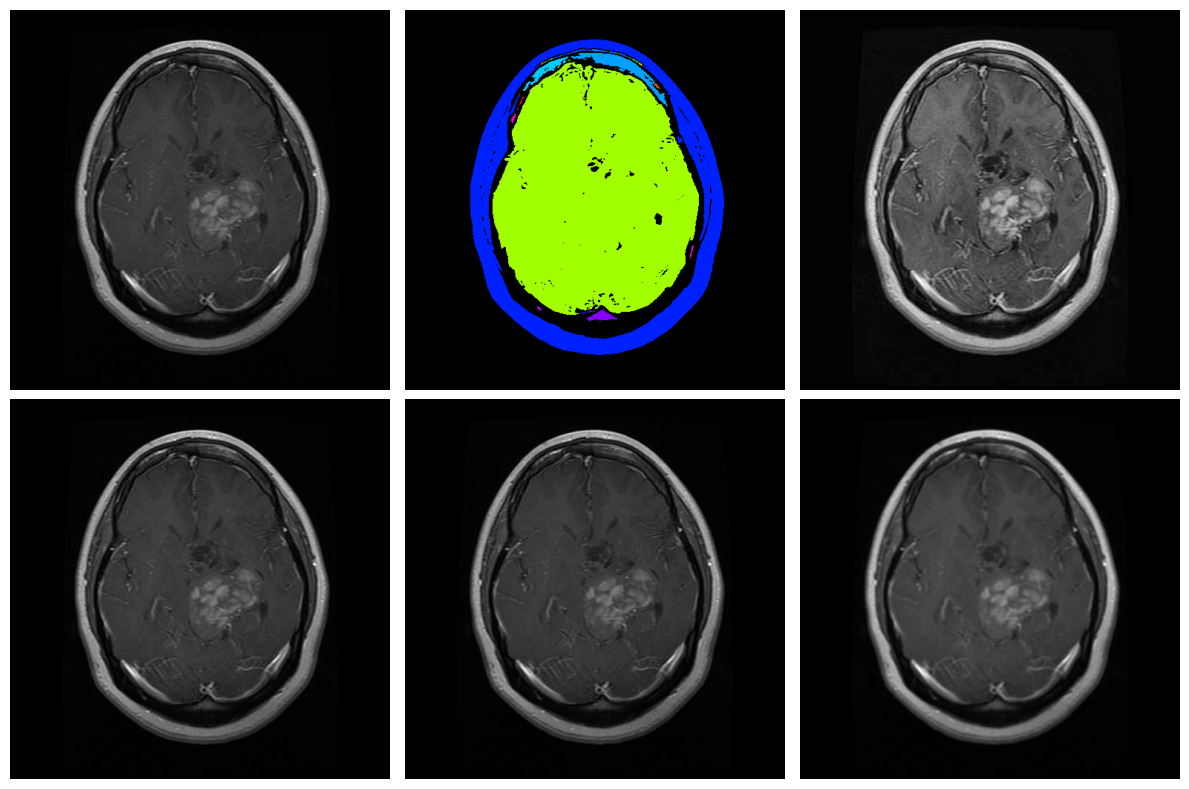

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < len(images):  # Sınır kontrolü
        ax.imshow(images[i], cmap="gray")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
train_dir = "/data/Training"
test_dir = "/data/Testing"


In [7]:
def custom_preprocessing(image):
    # Normalize (rescale)
    image = image / 255.0

    # Histogram Equalization (CLAHE)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Grayscale if needed
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image.astype(np.uint8))

    # Reshape back to add channel dimension (1 for grayscale or 3 for RGB)
    image = np.expand_dims(image, axis=-1)  # For grayscale channel dimension
    image = np.repeat(image, 3, axis=-1)  # Convert to 3-channel RGB-like shape (224, 224, 3)

    # Blur to reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)

    return image.astype('float32') / 255.0

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=custom_preprocessing
)


test_datagen = ImageDataGenerator(
    rescale=1./255,
    #preprocessing_function=custom_preprocessing
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    "./"+train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode= "categorical"
)

Found 2870 images belonging to 4 classes.


In [10]:
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", mode="max", verbose=1, min_delta=1e-7, restore_best_weights=True)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1, min_delta=1e-7)
    
    callback_list = [
        early_stop, 
        reduce_learning_rate
        ]
    return callback_list

callback_list = create_callback("best_model")   

In [11]:
from tensorflow.keras.applications import VGG16, VGG19, Xception, InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.regularizers import l1, l2

base_model = VGG19(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

In [12]:
for layer in base_model.layers[:12]:  # Freeze the first 12 layers
    layer.trainable = False
for layer in base_model.layers[12:]:  # Unfreeze remaining layers
    layer.trainable = True

In [13]:
name="MobileNet"

model = tf.keras.Sequential([tf.keras.Input(shape=(150, 150, 3), name="input_layer"),
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
                    tf.keras.layers.Dropout(0.3),
                    tf.keras.layers.Dense(4, activation='softmax')
                    ], name=name)

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy','mse'] 
)


In [15]:
model.summary()

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,092,612 (76.65 MB)

 Trainable params: 17,766,020 (67.77 MB)

 Non-trainable params: 2,326,592 (8.88 MB)

In [16]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch= train_generator.samples // train_generator.batch_size,
    batch_size=32,
    callbacks=callback_list
)

Epoch 1/20


c:\Users\telat\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.6466 - loss: 0.9034 - mse: 0.1171 - learning_rate: 3.0000e-05
Epoch 2/20


c:\Users\telat\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,mse
  current = self.get_monitor_value(logs)
c:\Users\telat\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 125us/step - accuracy: 0.7500 - loss: 0.7328 - mse: 0.0937 - learning_rate: 3.0000e-05
Epoch 3/20


c:\Users\telat\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


89/89 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.8797 - loss: 0.3549 - mse: 0.0445 - learning_rate: 3.0000e-05
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 45us/step - accuracy: 0.9375 - loss: 0.2824 - mse: 0.0315 - learning_rate: 3.0000e-05
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.9248 - loss: 0.2386 - mse: 0.0286 - learning_rate: 3.0000e-05
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 45us/step - accuracy: 0.9375 - loss: 0.1815 - mse: 0.0222 - learning_rate: 3.0000e-05
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.9610 - loss: 0.1405 - mse: 0.0158 - learning_rate: 3.0000e-05
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 57us/step - accuracy: 0.9375 - loss: 0.1721 - mse: 0.0234 - learning_rate: 3.0000e-05
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.9714 - loss: 0.1071 - mse: 0.0103 - learning_rate: 3.0000e-05
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 57us/step - accuracy: 0.9688 - loss: 0.0699 - mse: 0.0059 - learning_rate: 3.000

In [17]:
acc = history.history["accuracy"]
loss = history.history["loss"]


'\nplt.subplot(1,2,2)\nplt.plot(epochs, loss, label="Traning Loss")\nplt.plot(epochs, val_loss, label="Validation Loss")\nplt.title("Loss")\nplt.legend()\n'

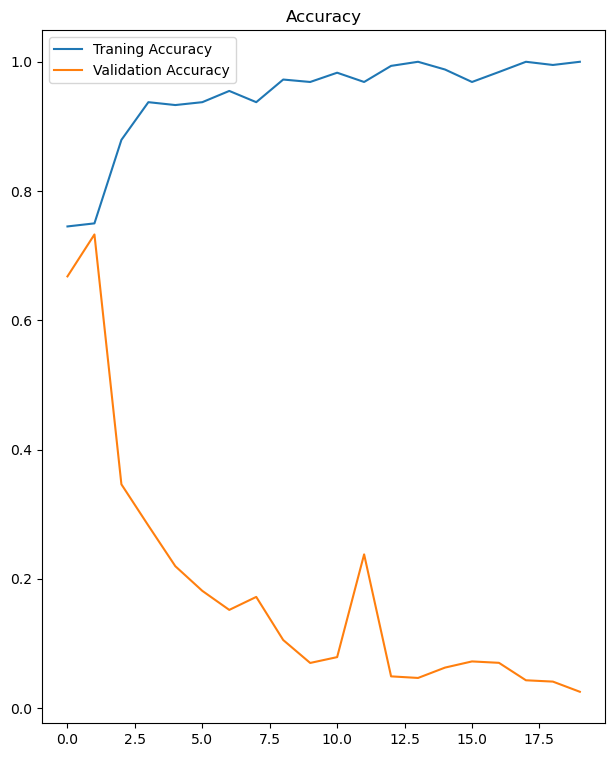

In [18]:


plt.figure(figsize=(16,9))

epochs = range(len(history.history['accuracy']))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label="Traning Accuracy")
plt.plot(epochs, loss, label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

"""
plt.subplot(1,2,2)
plt.plot(epochs, loss, label="Traning Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Loss")
plt.legend()
"""

In [19]:
import numpy as np

test_generator = test_datagen.flow_from_directory(
    "./" + test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)

predicted_classes = predictions.argmax(axis=-1)

test_loss, test_accuracy, *_ = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")





Found 394 images belonging to 4 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5729 - loss: 3.1799 - mse: 0.1929
Test Accuracy: 73.44%


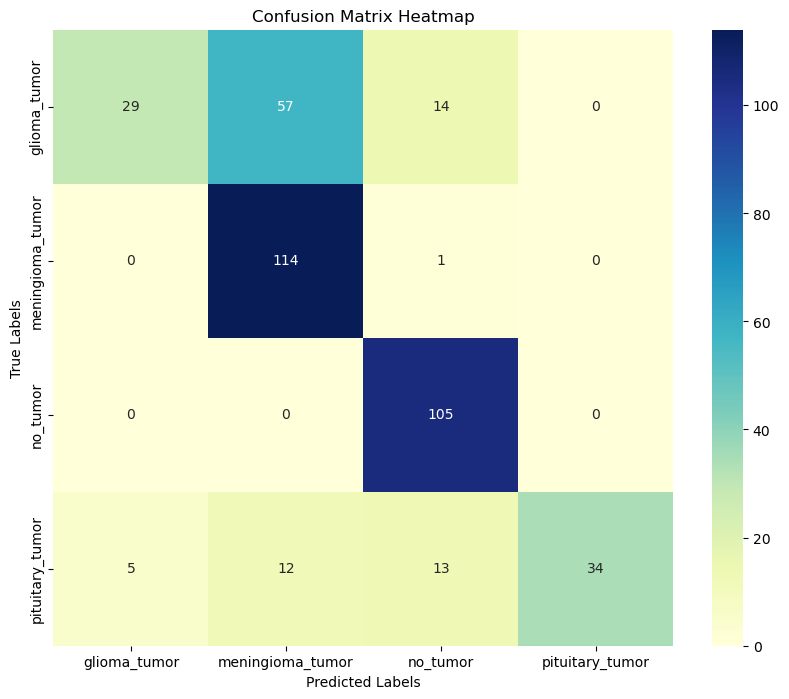

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_labels[:len(predicted_classes)], predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [21]:
print(classification_report(true_labels[:len(predicted_classes)], predicted_classes))

              precision    recall  f1-score   support

           0       0.85      0.29      0.43       100
           1       0.62      0.99      0.77       115
           2       0.79      1.00      0.88       105
           3       1.00      0.53      0.69        64

    accuracy                           0.73       384
   macro avg       0.82      0.70      0.69       384
weighted avg       0.79      0.73      0.70       384

